# Task 5: Adversarial Attacks on Robust vs Lazy Models

This notebook evaluates clean performance and adversarial robustness for:
- **Robust model** (Task 4 teacher): `../task4/TEA/outputs/teacher_weights.pt`
- **Lazy model** (Task 1): `../task1/saved_models/cnn_weights_feb1_GODLYPULL.pth`

We will:
1. Evaluate both models on the Colored MNIST train/test splits.
2. Generate FGSM adversarial examples and evaluate performance.
3. Perform targeted attacks (target class = 3) on 10 random images of digit 7, measuring the minimum perturbation needed for >90% confidence.


In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
# Paths
REPO_ROOT = Path("..").resolve()
COLORED_ROOT = REPO_ROOT / "task0" / "outputs" / "colored-mnist"
TEACHER_WEIGHTS = REPO_ROOT / "task4" / "TEA" / "outputs" / "teacher_weights.pt"
LAZY_WEIGHTS = REPO_ROOT / "task1" / "saved_models" / "cnn_weights_feb1_GODLYPULL.pth"

print("COLORED_ROOT:", COLORED_ROOT, "exists:", COLORED_ROOT.exists())
print("TEACHER_WEIGHTS:", TEACHER_WEIGHTS, "exists:", TEACHER_WEIGHTS.exists())
print("LAZY_WEIGHTS:", LAZY_WEIGHTS, "exists:", LAZY_WEIGHTS.exists())

BASE_TRANSFORM = transforms.ToTensor()

def load_meta(root: Path, split: str) -> pd.DataFrame:
    path = root / split / "labels.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found. Generate colored-mnist first.")
    meta = pd.read_csv(path)
    if "filename" not in meta.columns or "label" not in meta.columns:
        raise ValueError("labels.csv must contain columns: filename, label")
    meta["label"] = meta["label"].astype(int)
    return meta


def _load_rgb(root: Path, split: str, filename: str) -> torch.Tensor:
    path = root / split / "images" / filename
    return BASE_TRANSFORM(Image.open(path).convert("RGB"))


class ColoredMNISTDataset(Dataset):
    def __init__(self, root: Path, split: str):
        assert split in {"train", "test"}
        self.root = root
        self.split = split
        self.meta = load_meta(root, split)

    def __len__(self) -> int:
        return len(self.meta)

    def __getitem__(self, idx: int):
        row = self.meta.iloc[int(idx)]
        x = _load_rgb(self.root, self.split, str(row.filename))
        y = int(row.label)
        return x, y


def strip_background(x: torch.Tensor, threshold: float = 0.9) -> torch.Tensor:
    """Teacher preprocessing: digit-only on black background (per TEA instructions)."""
    gray = x.mean(dim=1, keepdim=True)
    mask = (gray > threshold).float()
    return x * mask


train_dataset = ColoredMNISTDataset(COLORED_ROOT, "train")
test_dataset = ColoredMNISTDataset(COLORED_ROOT, "test")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

COLORED_ROOT: /home/bonda/Documents/precog_application/cv-task/task0/outputs/colored-mnist exists: True
TEACHER_WEIGHTS: /home/bonda/Documents/precog_application/cv-task/task4/TEA/outputs/teacher_weights.pt exists: True
LAZY_WEIGHTS: /home/bonda/Documents/precog_application/cv-task/task1/saved_models/cnn_weights_feb1_GODLYPULL.pth exists: True
Train samples: 60000
Test samples: 10000


In [3]:
# --- Model definition (matches task1/task4) ---
class ThreeLayerCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        conv1_features = 8
        conv2_features = 16

        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(conv2_features * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu_fc = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)
        return x


# --- Load models ---
robust_model = ThreeLayerCNN().to(device)
lazy_model = ThreeLayerCNN().to(device)

robust_model.load_state_dict(torch.load(TEACHER_WEIGHTS, map_location=device))
lazy_model.load_state_dict(torch.load(LAZY_WEIGHTS, map_location=device))

robust_model.eval()
lazy_model.eval()

print("Loaded robust model weights:", TEACHER_WEIGHTS)
print("Loaded lazy model weights:", LAZY_WEIGHTS)

Loaded robust model weights: /home/bonda/Documents/precog_application/cv-task/task4/TEA/outputs/teacher_weights.pt
Loaded lazy model weights: /home/bonda/Documents/precog_application/cv-task/task1/saved_models/cnn_weights_feb1_GODLYPULL.pth


In [4]:
def preprocess_for_model(x: torch.Tensor, model_kind: str) -> torch.Tensor:
    if model_kind == "robust":
        return strip_background(x)
    if model_kind == "lazy":
        return x
    raise ValueError("model_kind must be 'robust' or 'lazy'")


def evaluate_accuracy(model: nn.Module, loader: DataLoader, model_kind: str) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x_in = preprocess_for_model(x, model_kind)
            logits = model(x_in)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()
    return 100.0 * correct / max(total, 1)


def predict_confidence(model: nn.Module, x: torch.Tensor, model_kind: str) -> torch.Tensor:
    model.eval()
    x_in = preprocess_for_model(x, model_kind)
    logits = model(x_in)
    probs = F.softmax(logits, dim=1)
    return probs

In [5]:
# 1) Clean evaluation on Colored MNIST (train/test)
clean_results = []
for split_name, loader in [("train", train_loader), ("test", test_loader)]:
    acc_robust = evaluate_accuracy(robust_model, loader, "robust")
    acc_lazy = evaluate_accuracy(lazy_model, loader, "lazy")
    clean_results.append({
        "split": split_name,
        "robust_acc": acc_robust,
        "lazy_acc": acc_lazy,
    })

clean_df = pd.DataFrame(clean_results)
print("Clean accuracy (%)")
print(clean_df)

/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Clean accuracy (%)
   split  robust_acc  lazy_acc
0  train      95.825    93.305
1   test      95.840     0.440


In [6]:
def fgsm_attack(x: torch.Tensor, grad: torch.Tensor, epsilon: float, targeted: bool) -> torch.Tensor:
    if targeted:
        return x - epsilon * grad.sign()
    return x + epsilon * grad.sign()


def evaluate_fgsm_accuracy(
    model: nn.Module,
    loader: DataLoader,
    model_kind: str,
    epsilon: float,
) -> float:
    model.eval()
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        # Build input for model and compute gradient
        x_in = preprocess_for_model(x, model_kind).detach().clone()
        x_in.requires_grad_(True)

        logits = model(x_in)
        loss = F.cross_entropy(logits, y)
        model.zero_grad(set_to_none=True)
        loss.backward()

        x_adv = fgsm_attack(x_in, x_in.grad, epsilon, targeted=False)
        x_adv = torch.clamp(x_adv, 0.0, 1.0)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds = logits_adv.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()

    return 100.0 * correct / max(total, 1)


# 2) FGSM attack evaluation (untargeted)
FGSM_EPS = 0.1
fgsm_results = []
for split_name, loader in [("train", train_loader), ("test", test_loader)]:
    acc_robust = evaluate_fgsm_accuracy(robust_model, loader, "robust", FGSM_EPS)
    acc_lazy = evaluate_fgsm_accuracy(lazy_model, loader, "lazy", FGSM_EPS)
    fgsm_results.append({
        "split": split_name,
        "epsilon": FGSM_EPS,
        "robust_adv_acc": acc_robust,
        "lazy_adv_acc": acc_lazy,
    })

fgsm_df = pd.DataFrame(fgsm_results)
print("FGSM accuracy (%) with epsilon =", FGSM_EPS)
print(fgsm_df)

/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


FGSM accuracy (%) with epsilon = 0.1
   split  epsilon  robust_adv_acc  lazy_adv_acc
0  train      0.1       56.306667      4.656667
1   test      0.1       57.780000      0.000000


In [7]:
def get_random_sevens(dataset: ColoredMNISTDataset, n: int = 10, seed: int = 42):
    rng = np.random.default_rng(seed)
    idxs = dataset.meta.index[dataset.meta["label"] == 7].to_numpy()
    if len(idxs) < n:
        raise ValueError("Not enough '7' samples in test set.")
    chosen = rng.choice(idxs, size=n, replace=False)
    images = []
    labels = []
    for idx in chosen:
        x, y = dataset[int(idx)]
        images.append(x)
        labels.append(y)
    return torch.stack(images), torch.tensor(labels)


def targeted_fgsm_min_eps_per_image(
    model: nn.Module,
    x: torch.Tensor,
    target_class: int,
    model_kind: str,
    eps_grid: np.ndarray,
    conf_threshold: float = 0.90,
):
    x_in = preprocess_for_model(x, model_kind).detach().clone().to(device)
    min_eps = [None] * x_in.size(0)
    min_conf = [None] * x_in.size(0)

    for i in range(x_in.size(0)):
        xi = x_in[i : i + 1]
        found = False
        for eps in eps_grid:
            xi_adv = xi.detach().clone()
            xi_adv.requires_grad_(True)
            logits = model(xi_adv)
            target = torch.tensor([target_class], device=device, dtype=torch.long)
            loss = F.cross_entropy(logits, target)
            model.zero_grad(set_to_none=True)
            loss.backward()

            xi_adv = fgsm_attack(xi_adv, xi_adv.grad, float(eps), targeted=True)
            xi_adv = torch.clamp(xi_adv, 0.0, 1.0)

            with torch.no_grad():
                probs = F.softmax(model(xi_adv), dim=1)
                conf = float(probs[0, target_class].item())

            if conf >= conf_threshold:
                min_eps[i] = float(eps)
                min_conf[i] = conf
                found = True
                break
        if not found:
            min_eps[i] = None
            min_conf[i] = None

    return min_eps, min_conf


def targeted_pgd_min_eps_per_image(
    model: nn.Module,
    x: torch.Tensor,
    target_class: int,
    model_kind: str,
    eps_grid: np.ndarray,
    steps: int = 40,
    conf_threshold: float = 0.90,
):
    x_in = preprocess_for_model(x, model_kind).detach().clone().to(device)
    min_eps = [None] * x_in.size(0)
    min_conf = [None] * x_in.size(0)

    for i in range(x_in.size(0)):
        xi = x_in[i : i + 1]
        found = False
        for eps in eps_grid:
            eps = float(eps)
            alpha = max(eps / 5.0, 1e-4)
            xi_adv = xi.detach().clone()

            for _ in range(steps):
                xi_adv.requires_grad_(True)
                logits = model(xi_adv)
                target = torch.tensor([target_class], device=device, dtype=torch.long)
                loss = F.cross_entropy(logits, target)
                model.zero_grad(set_to_none=True)
                loss.backward()

                with torch.no_grad():
                    xi_adv = xi_adv - alpha * xi_adv.grad.sign()
                    delta = torch.clamp(xi_adv - xi, min=-eps, max=eps)
                    xi_adv = torch.clamp(xi + delta, 0.0, 1.0)

            with torch.no_grad():
                probs = F.softmax(model(xi_adv), dim=1)
                conf = float(probs[0, target_class].item())

            if conf >= conf_threshold:
                min_eps[i] = eps
                min_conf[i] = conf
                found = True
                break
        if not found:
            min_eps[i] = None
            min_conf[i] = None

    return min_eps, min_conf


# 3) Targeted attacks: 10 random '7' images -> target class 3
TARGET_CLASS = 3
CONF_THRESH = 0.90
EPS_GRID = np.linspace(0.0, 1, 1000)  # epsilon < 0.05 constraint

x7, y7 = get_random_sevens(test_dataset, n=10, seed=SEED)
print("Selected labels:", y7.tolist())

results = []
for model_name, model, model_kind in [
    ("robust", robust_model, "robust"),
    ("lazy", lazy_model, "lazy"),
]:
    # FGSM targeted (per image)
    fgsm_eps, fgsm_conf = targeted_fgsm_min_eps_per_image(
        model, x7, TARGET_CLASS, model_kind, EPS_GRID, CONF_THRESH
    )

    # PGD targeted (per image)
    pgd_eps, pgd_conf = targeted_pgd_min_eps_per_image(
        model, x7, TARGET_CLASS, model_kind, EPS_GRID, steps=40, conf_threshold=CONF_THRESH
    )

    for i in range(len(fgsm_eps)):
        results.append({
            "model": model_name,
            "image_idx": i,
            "target_class": TARGET_CLASS,
            "fgsm_min_eps": fgsm_eps[i],
            "pgd_min_eps": pgd_eps[i],
            "fgsm_conf": fgsm_conf[i],
            "pgd_conf": pgd_conf[i],
        })

results_df = pd.DataFrame(results)
print("Targeted attack results (10 images of '7' -> '3')")
print(results_df)

# Quantify noise magnitude difference
summary = (
    results_df
    .groupby("model")
    .agg(
        fgsm_success_rate=("fgsm_min_eps", lambda s: s.notna().mean()),
        pgd_success_rate=("pgd_min_eps", lambda s: s.notna().mean()),
        fgsm_mean_eps=("fgsm_min_eps", lambda s: np.nanmean(s.astype(float))),
        pgd_mean_eps=("pgd_min_eps", lambda s: np.nanmean(s.astype(float))),
    )
    .reset_index()
)

print("\nNoise magnitude comparison (lower is more vulnerable):")
print(summary)

Selected labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Targeted attack results (10 images of '7' -> '3')
     model  image_idx  target_class  fgsm_min_eps  pgd_min_eps  fgsm_conf  \
0   robust          0             3      0.253253     0.158158   0.900706   
1   robust          1             3      0.227227     0.195195   0.902802   
2   robust          2             3      0.359359     0.137137   0.900270   
3   robust          3             3      0.122122     0.115115   0.900344   
4   robust          4             3      0.208208     0.176176   0.900323   
5   robust          5             3           NaN     0.122122        NaN   
6   robust          6             3      0.189189     0.158158   0.900745   
7   robust          7             3           NaN     0.126126        NaN   
8   robust          8             3           NaN     0.116116        NaN   
9   robust          9             3           NaN     0.156156        NaN   
10    lazy          0             3      0.203203     0

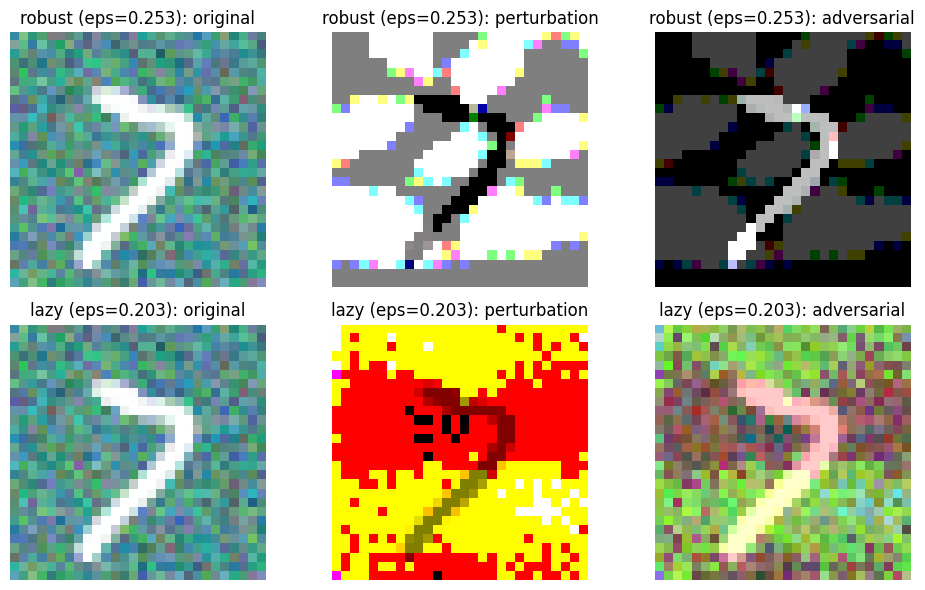

In [8]:
import matplotlib.pyplot as plt


def _make_targeted_fgsm_adv(model: nn.Module, x: torch.Tensor, target_class: int, model_kind: str, eps: float):
    x_in = preprocess_for_model(x, model_kind).detach().clone().to(device)
    x_adv = x_in.detach().clone()
    x_adv.requires_grad_(True)

    logits = model(x_adv)
    target = torch.tensor([target_class], device=device, dtype=torch.long)
    loss = F.cross_entropy(logits, target)
    model.zero_grad(set_to_none=True)
    loss.backward()

    x_adv = fgsm_attack(x_adv, x_adv.grad, float(eps), targeted=True)
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return x_in.detach().cpu(), x_adv.detach().cpu()


def _best_fgsm_under_grid(model: nn.Module, x: torch.Tensor, target_class: int, model_kind: str, eps_grid: np.ndarray):
    x_in = preprocess_for_model(x, model_kind).detach().clone().to(device)
    x_in.requires_grad_(True)

    logits = model(x_in)
    target = torch.tensor([target_class], device=device, dtype=torch.long)
    loss = F.cross_entropy(logits, target)
    model.zero_grad(set_to_none=True)
    loss.backward()

    grad_sign = x_in.grad.sign()
    best = {"eps": None, "conf": -1.0, "x_adv": None}
    for eps in eps_grid:
        x_adv = torch.clamp(x_in - float(eps) * grad_sign, 0.0, 1.0)
        with torch.no_grad():
            conf = float(F.softmax(model(x_adv), dim=1)[0, target_class].item())
        if conf > best["conf"]:
            best = {"eps": float(eps), "conf": conf, "x_adv": x_adv.detach().cpu()}

    return x_in.detach().cpu(), best


def _plot_triplet(ax_row, x_orig, x_in, x_adv, title_prefix: str):
    # Original (always colored MNIST input)
    ax_row[0].imshow(x_orig.permute(1, 2, 0))
    ax_row[0].set_title(f"{title_prefix}: original")
    ax_row[0].axis("off")

    # Perturbation (visualized)
    pert = x_adv - x_in
    pert_vis = (pert - pert.min()) / (pert.max() - pert.min() + 1e-8)
    ax_row[1].imshow(pert_vis.permute(1, 2, 0))
    ax_row[1].set_title(f"{title_prefix}: perturbation")
    ax_row[1].axis("off")

    # Adversarial
    ax_row[2].imshow(x_adv.permute(1, 2, 0))
    ax_row[2].set_title(f"{title_prefix}: adversarial")
    ax_row[2].axis("off")


# Visualize one example per model (targeted FGSM)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for row_idx, (model_name, model, model_kind) in enumerate([
    ("robust", robust_model, "robust"),
    ("lazy", lazy_model, "lazy"),
]):
    sub = results_df[(results_df["model"] == model_name) & results_df["fgsm_min_eps"].notna()]
    if sub.empty:
        # No successful FGSM; show best-effort within epsilon grid
        idx = 0
        x_orig = x7[idx].detach().cpu()
        x_in, best = _best_fgsm_under_grid(model, x_orig.unsqueeze(0), TARGET_CLASS, model_kind, EPS_GRID)
        title = f"{model_name} (best eps={best['eps']:.3f}, conf={best['conf']:.2f})"
        _plot_triplet(axes[row_idx], x_orig, x_in[0], best["x_adv"][0], title)
        continue

    pick = sub.iloc[0]
    idx = int(pick["image_idx"])
    eps = float(pick["fgsm_min_eps"])

    x_orig = x7[idx].detach().cpu()
    x_in, x_adv = _make_targeted_fgsm_adv(model, x_orig.unsqueeze(0), TARGET_CLASS, model_kind, eps)
    _plot_triplet(axes[row_idx], x_orig, x_in[0], x_adv[0], f"{model_name} (eps={eps:.3f})")

plt.tight_layout()
plt.show()